# Imports

In [1]:
!pip install fiftyone

In [2]:
import os
import numpy as np
import transformers
import fiftyone
from PIL import Image
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from typing import Tuple, List
from sklearn.model_selection import train_test_split



In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# Data

In [4]:
dataset = fiftyone.zoo.load_zoo_dataset(
    "open-images-v7",
    max_samples=500,
    label_types=["classifications"],
    classes=["Cat", "Dog", "Car", "Tree", "Animal"],
)

Necessary images already downloaded
Existing download of split 'train' is sufficient
Necessary images already downloaded
Existing download of split 'test' is sufficient
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'open-images-v7-500'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Load and prepare your dataset. It should consist of at least 50k images from any openimages split.

In [5]:
# fiftyone.launch_app(dataset)

In [6]:
dataset

Name:        open-images-v7-500
Media type:  image
Num samples: 1500
Persistent:  False
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)

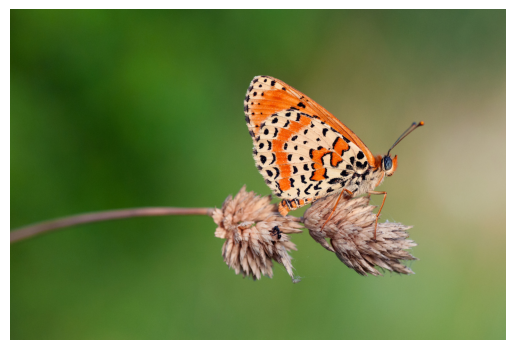

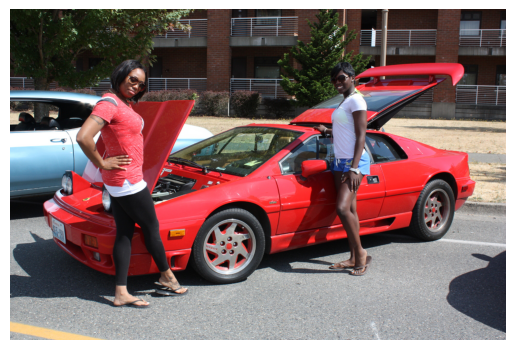

In [7]:
samples = dataset.take(2)

for sample in samples:
    image = Image.open(sample.filepath)
    plt.figure()
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

In [8]:
def show_image(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()


# Display images in a grid
def show_images(images: list):
    plt.figure(figsize=(15, 15))

    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


# Image augmentation and crops

Implement image augmentation and crops as described in DINO.

In [9]:
class RandomGrayscale(tf.keras.layers.Layer):
    def __init__(self, probability=0.1, **kwargs):
        super(RandomGrayscale, self).__init__(**kwargs)
        self.probability = probability

    def call(self, inputs, training=None, **kwargs):
        def apply_grayscale():
            grayscale_image = tf.image.rgb_to_grayscale(inputs)
            return tf.image.grayscale_to_rgb(grayscale_image)

        random_numbers = tf.random.uniform([], minval=0, maxval=1)
        should_apply_grayscale = random_numbers < self.probability
        output = tf.cond(should_apply_grayscale, apply_grayscale, lambda: inputs)
        return output

    def get_config(self):
        config = super(RandomGrayscale, self).get_config()
        config.update({'probability': self.probability})
        return config

In [43]:
class DataAugmentationDINO:
    def __init__(self, global_crops_scale, local_crops_scale, teacher_crops_number=4, student_crops_number=(2,2)):
        self.global_crops_scale = global_crops_scale
        self.local_crops_scale = local_crops_scale
        self.teacher_crops_number = teacher_crops_number
        self.student_global_crops_number, self.student_local_crops_number = student_crops_number

        self.student_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomContrast(factor=0.25),
            tf.keras.layers.RandomBrightness(factor=0.3),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.GaussianNoise(stddev=0.1),
            RandomGrayscale(probability=0.2),
            tf.keras.layers.Rescaling(scale=1. / 255)
        ])

        self.teacher_augmentation = tf.keras.Sequential([
            tf.keras.layers.Rescaling(scale=1. / 255)
        ])

    def __call__(self, image) -> Tuple[List[Image], List[Image]]:
        teacher_crops = []
        for _ in range(self.teacher_crops_number):
            teacher_crop = self._random_resized_crop(image, size=224, scale=self.global_crops_scale)
            teacher_crop = self.teacher_augmentation(teacher_crop)
            teacher_crops.append(teacher_crop)

        student_crops = []
        
        for _ in range(self.student_global_crops_number):
            student_global_crop = self._random_resized_crop(image, size=224, scale=self.global_crops_scale)
            student_global_crop = self.student_augmentation(student_global_crop)
            student_crops.append(student_global_crop)

        for _ in range(self.student_local_crops_number):
            student_local_crop = self._random_resized_crop(image, size=224, scale=self.local_crops_scale)
            student_local_crop = self.student_augmentation(student_local_crop)
            student_crops.append(student_local_crop)
            
        return teacher_crops, student_crops

    @staticmethod
    def _random_resized_crop(image, size, scale):
        height, width = tf.cast(tf.shape(image)[0], tf.float32), tf.cast(tf.shape(image)[1], tf.float32)
        crop_height = tf.random.uniform(shape=[], minval=tf.cast((height * scale[0]), tf.int32),
                                        maxval=tf.cast((height * scale[1]), tf.int32), dtype=tf.dtypes.int32)
        crop_width = tf.random.uniform(shape=[], minval=tf.cast((width * scale[0]), tf.int32),
                                       maxval=tf.cast((width * scale[1]), tf.int32), dtype=tf.dtypes.int32)

        cropped_image = tf.image.random_crop(image, size=[crop_height, crop_width, 3])
        resized_image = tf.image.resize(cropped_image, [size, size])

        return resized_image

In [44]:
augmentor = DataAugmentationDINO((0.5, 0.6), (0.25, 0.5), 4, (2,2))

In [224]:
def extract_single_label(sample):
    # print(sample)
    return sample.positive_labels.classifications[0].label


filtered_samples = [sample for sample in dataset if sample.positive_labels.classifications]

filepaths = [sample.filepath for sample in filtered_samples]
labels = [extract_single_label(sample) for sample in filtered_samples]


def load_image(filepath, label):
    img = tf.io.read_file(filepath)
    # print(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, dtype=tf.int32)
    return img, label


def load_and_preprocess_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, dtype=tf.int32)
    teacher_crops, student_crops = augmentor(img)

    return (teacher_crops, student_crops), label


tf_dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels)).map(load_and_preprocess_image)

crop_test_tf_dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels)).map(load_image)

# print(tf_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[0.48388788 0.5947939  0.73189175]
  [0.49575594 0.6036958  0.73519164]
  [0.4993387  0.60754615 0.73863566]
  ...
  [0.25582117 0.46473297 0.7034458 ]
  [0.25642228 0.46556646 0.70499724]
  [0.2591475  0.46722168 0.707993  ]]

 [[0.4406394  0.5714276  0.73084   ]
  [0.45566854 0.57836443 0.73518854]
  [0.48033926 0.59789705 0.7368111 ]
  ...
  [0.25300154 0.4546575  0.70385724]
  [0.25370672 0.4543775  0.70456225]
  [0.25716534 0.45858893 0.7079429 ]]

 [[0.40624878 0.54668003 0.7271353 ]
  [0.420027   0.554164   0.7287103 ]
  [0.44471768 0.5764564  0.7294797 ]
  ...
  [0.24795456 0.45461768 0.7042955 ]
  [0.24752253 0.4551836  0.7045638 ]
  [0.24416952 0.4536041  0.7027163 ]]

 ...

 [[0.20837353 0.2825116  0.31191236]
  [0.21310249 0.28621784 0.3158702 ]
  [0.20050383 0.26488948 0.29238948]
  ...
  [0.48817122 0.48370105 0.46741977]
  [0.5454243  0.535283   0.4966319 ]
  [0.48080143 0.4875791  0.4663642 ]]

 [[0.21705827 0.2877749  0.32833162]
  [0.2316219  0.302609   0

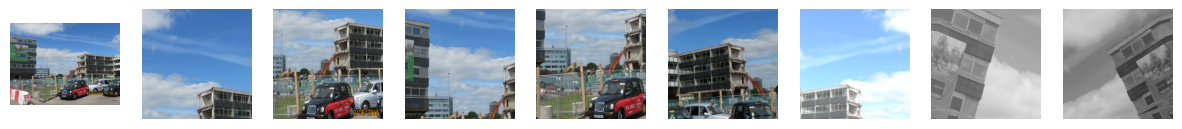

In [225]:
img = next(iter(crop_test_tf_dataset))[0]
global_crops, local_crops = augmentor.__call__(img)
print(local_crops[0])

show_images([img] + global_crops + local_crops)

# Losses

Implement the losses and loss additions. DINO, koleo, sinkhorn_knopp, softmax_centering.

In [226]:
class DinoLossLight(tf.keras.losses.Loss):
    def __init__(self, teacher_temp, student_temp):
        super(DinoLossLight, self).__init__()
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp

    def call(self, teacher_output, student_output):
        teacher_output = tf.math.l2_normalize(teacher_output, axis=1)
        student_output = tf.math.l2_normalize(student_output, axis=1)

        teacher_output = teacher_output / self.teacher_temp
        student_output = student_output / self.student_temp

        soft_teacher_output = tf.nn.softmax(teacher_output)
        soft_student_output = tf.nn.softmax(student_output)

        loss = tf.keras.losses.categorical_crossentropy(soft_teacher_output, soft_student_output, from_logits=False)
        return tf.reduce_mean(loss)

In [267]:
class DinoLoss(tf.keras.losses.Loss):
    def __init__(self, out_dim, teacher_temp, student_temp=0.1, center_momentum=0.9):
        super(DinoLoss, self).__init__()
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.center = tf.Variable(tf.zeros((1, out_dim)), trainable=False)

    def call(self, teacher_output, student_output):
        teacher_output = tf.math.l2_normalize(teacher_output, axis=1)
        student_output = tf.math.l2_normalize(student_output, axis=1)
        
        self.update_center(teacher_output)

        soft_teacher_output = tf.nn.softmax((teacher_output - self.center) / self.teacher_temp, axis=1)
        soft_student_output = tf.nn.softmax(student_output / self.student_temp, axis=1)

        loss = tf.keras.losses.categorical_crossentropy(soft_teacher_output, soft_student_output, from_logits=False)
        return tf.reduce_mean(loss)

    def update_center(self, teacher_output):
        teacher_mean = tf.reduce_mean(teacher_output, axis=0, keepdims=True)
        new_center = self.center_momentum * self.center + (1 - self.center_momentum) * teacher_mean
        # print("Center ", new_center)
        self.center.assign(new_center)


# Backbone

In [268]:
def get_name(*args: str, sep: str = '/') -> str:
    return sep.join(args)

Implement a transformer model as described in DINO, including the DINO head. Don't forget the teacher weights update.

In [269]:
class DinoHead(tf.keras.models.Model):
    def __init__(self, input_dimension, out_dim):
        super(DinoHead, self).__init__()
        self.dense_layers = [
            tf.keras.layers.Dense(512, activation='selu', input_shape=(input_dimension,)),
            tf.keras.layers.Dense(512, activation='selu'),
            tf.keras.layers.Dense(256, activation='selu'),
        ]
        self.norm_layer = tf.keras.layers.LayerNormalization()
        self.output_layer = tf.keras.layers.Dense(out_dim)

    def call(self, input_tensor, training=None, mask=None):
        x = input_tensor
        for dense in self.dense_layers:
            x = dense(x)
        x = self.norm_layer(x)
        return self.output_layer(x)


In [270]:
class Dino(tf.keras.Model):
    def __init__(self, teacher, student, loss, optimizer, alpha=0.9):
        super(Dino, self).__init__()
        self.teacher = teacher
        self.student = student
        self.loss = loss
        self.alpha = alpha
        self.optimizer = optimizer

    def train_step(self, data):
        teacher_input, student_input = data

        with tf.GradientTape() as tape:
            teacher_output = self.teacher(teacher_input, training=False)
            student_output = self.student(student_input, training=True)

            loss_value = self.loss(teacher_output, student_output)

        gradients = tape.gradient(loss_value, student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        self._update_teacher_weights()
        return loss_value

    def call(self, inputs, training=False, mask=None):
        return self.student(inputs, training=training) if training else self.teacher(inputs, training=False)

    def _update_teacher_weights(self):
        for teacher_param, student_param in zip(self.teacher.trainable_variables, self.student.trainable_variables):
            teacher_param.assign(self.alpha * teacher_param + (1 - self.alpha) * student_param)



In [271]:
class ClsTokenLayer(tf.keras.layers.Layer):
    def __init__(self, out_dim):
        super(ClsTokenLayer, self).__init__()
        self.cls_token = self.add_weight(shape=(1, out_dim), initializer='zeros', trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_token = tf.tile(self.cls_token, [batch_size, 1])
        return tf.keras.layers.concatenate([cls_token, inputs], axis=1)


In [272]:
class HeadedBackbone(tf.keras.Model):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def call(self, inputs, training=False, mask=None):
        x = self.backbone(inputs, training=training)
        return self.head(x, training=training)

In [273]:
class Backbone(tf.keras.Model):
    def __init__(self, out_dim, dropout_rate=0.3):
        super(Backbone, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(224, 3, padding='same', activation='selu')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.conv2 = tf.keras.layers.Conv2D(112, 3, padding='same', activation='selu')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.conv3 = tf.keras.layers.Conv2D(56, 3, padding='same', activation='selu')
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
        self.conv4 = tf.keras.layers.Conv2D(23, 3, padding='same', activation='selu')
        self.pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout4 = tf.keras.layers.Dropout(dropout_rate)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(out_dim)

    def call(self, inputs, training=False, mask=None):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x, training=training)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x, training=training)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout4(x, training=training)
        x = self.flatten(x)
        return self.dense1(x)


In [274]:
class BackboneWithClsToken(tf.keras.Model):
    def __init__(self, out_dim, dropout_rate=0.3):
        super(BackboneWithClsToken, self).__init__()
        self.backbone = Backbone(out_dim, dropout_rate)
        self.cls_token_layer = ClsTokenLayer(out_dim)

    def call(self, inputs, training=False, mask = None):
        x = self.backbone(inputs, training=training)
        x = self.cls_token_layer(x)
        return x

In [275]:
dino_head = DinoHead(input_dimension=512, out_dim=10)
dino_loss = DinoLoss(out_dim=10, teacher_temp=0.05, student_temp=0.1, center_momentum=0.8)

backbone = BackboneWithClsToken(out_dim=512)
teacher = HeadedBackbone(backbone=backbone, head=dino_head)
student = HeadedBackbone(backbone=backbone, head=dino_head)

# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)


optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
dino = Dino(teacher=teacher, student=student, loss=dino_loss,
            optimizer=optimizer, alpha=0.8)

# Training

Train the model as described in DINO.

In [276]:
num_epochs = 3

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")

    epoch_loss_avg = tf.keras.metrics.Mean()

    for images, _ in tqdm.tqdm(tf_dataset, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        loss_value = dino.train_step(images)
        print(f"Loss: {loss_value.numpy()}")
        # show_images(global_crops_batch)
        # show_images(local_crops_batch)
        epoch_loss_avg.update_state(loss_value)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss_avg.result().numpy()}")

Epoch 1


Epoch 1/3:   0%|          | 0/1464 [00:00<?, ?it/s]

Loss: 5.450082302093506
Loss: 0.13445110619068146
Loss: 0.02232254669070244
Loss: 0.026977568864822388
Loss: 0.07895737141370773
Loss: 0.22578486800193787
Loss: 0.5473649501800537
Loss: 1.401082992553711
Loss: 3.122607707977295
Loss: 4.66986608505249


KeyboardInterrupt: 

# Evaluation

Show that features extracted by your model are similar for similar images and different for others.

# Bonus

Train a simple classification model on top of your extracted features on some simple dataset.